In [1]:
import pandas as pd
import pickle as pkl
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style = "darkgrid")

In [2]:
'''
!py -3.9 venv manzi
!pip install pandas
!pip install seaborn
!pip install fsspec
!pip install s3fs
!pip install boto
!pip install pgmpy
!pip install scikit-learn
!pip install prince
'''

'\n!pip install pandas\n!pip install seaborn\n!pip install fsspec\n!pip install s3fs\n!pip install boto\n'

### pkmgo feature

- appearedHour (c)
- appearedTimeOfDay (c)
- appearedDayOfWeek (c)
- appearedMonth (c)
- terrainType (c)
- closeToWater (01)
- weather (c)

- temperature (n)
- windSpeed (n)
- windBearing (n)
- pressure (n)
- sunriseMinutesMidnight (n)
- population density (n)
- urban-rural (c)
- gymDistanceKm (n)
- pokestopDistanceKm (n)

- coocc_xxx (b)

### description
- pokemonId - the identifier of a pokemon, should be deleted to not affect predictions. (numeric; ranges between 1 and 151)
- latitude, longitude - coordinates of a sighting (numeric)
- appearedLocalTime - exact time of a sighting in format yyyy-mm-dd'T'hh-mm-ss.ms'Z' (nominal)
- cellId 90-5850m - geographic position projected on a S2 Cell, with cell sizes ranging from 90 to 5850m (numeric)
- appearedTimeOfDay - time of the day of a sighting (night, evening, afternoon, morning)
- appearedHour/appearedMinute - local hour/minute of a sighting (numeric)
- appearedDayOfWeek - week day of a sighting (Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday)
- appearedDay/appearedMonth/appearedYear - day/month/year of a sighting (numeric)
- terrainType - terrain where pokemon appeared described with help of GLCF Modis Land Cover (numeric)
- closeToWater - did pokemon appear close (100m or less) to water (Boolean, same source as above)
- city - the city of a sighting (nominal)
- continent (not always parsed right) - the continent of a sighting (nominal)
- weather - weather type during a sighting (Foggy Clear, PartlyCloudy, MostlyCloudy, Overcast, Rain, BreezyandOvercast, LightRain, Drizzle, BreezyandPartlyCloudy, HeavyRain, BreezyandMostlyCloudy, Breezy, Windy, WindyandFoggy, Humid, Dry, WindyandPartlyCloudy, DryandMostlyCloudy, DryandPartlyCloudy, DrizzleandBreezy, LightRainandBreezy, HumidandPartlyCloudy, HumidandOvercast, RainandWindy) // Source for all weather features
- temperature - temperature in celsius at the location of a sighting (numeric)
- windSpeed - speed of the wind in km/h at the location of a sighting (numeric)
- windBearing - wind direction (numeric)
- pressure - atmospheric pressure in bar at the location of a sighting (numeric)
- weatherIcon - a compact representation of the weather at the location of a sighting (fog, clear-night, partly-cloudy-night, partly-cloudy-day, cloudy, clear-day, rain, wind)
- sunriseMinutesMidnight-sunsetMinutesBefore - time of appearance relatively to sunrise/sunset Source
- population density - what is the population density per square km of a sighting (numeric, Source)
- urban-rural - how urban is location where pokemon appeared (Boolean, built on Population density, <200 for rural, >=200 and <400 for midUrban, >=400 and <800 for subUrban, >800 for urban)
- gymDistanceKm, pokestopDistanceKm - how far is the nearest gym/pokestop in km from a sighting? (numeric, extracted from this dataset)
- gymIn100m-pokestopIn5000m - is there a gym/pokestop in 100/200/etc meters? (Boolean)
- cooc 1-cooc 151 - co-occurrence with any other pokemon (pokemon ids range between 1 and 151) within 100m distance and within the last 24 hours (Boolean)
- class - says which pokemonId it is, to be predicted.

### pkmdex feature
- Stamina (n)
- Attack (n)
- Defense (n)

- type x19 (b) 

- MaxHP (n)
- Capture_rate (n/c)
- Escape_rate (n/c)
- Weight (n)
- Height (n)
- Legendary (b)
- MaxCP (n)

In [3]:
pkmdex = pd.read_csv('data/pkmdex.csv')[:151]
types = set(pkmdex.Primary).union(set(pkmdex.Secondary))
types.remove('None')
for t in types:
    pkmdex[t] = False
    for i, r in pkmdex.iterrows():
        pkmdex.at[i, t] = (t == r.Primary) or ( t == r.Secondary)

In [4]:
pkmgo = pd.read_csv('data/pkmgo.csv')

c:\Users\martin.ranieri\Downloads\spawn-em-all-manzi-2022\manzi\lib\site-packages\IPython\core\interactiveshell.py:3251: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
#"', '".join(df.columns)
_ = [
'Name', 'Pokedex', 'pokemonId', 'class', 'Generation',

'Stamina', 'Attack', 'Defense', 'MaxHP', 'MaxCP',

'Primary', 'Secondary',

'Capture_rate', 'Escape_rate', 'Legendary',

'Weight', 'Height',

# stamp
'latitude', 'longitude', 'appearedLocalTime', '_id',

# S2 SYSTEM
'cellId_90m', 'cellId_180m', 'cellId_370m', 'cellId_730m', 'cellId_1460m', 'cellId_2920m', 'cellId_5850m',

# time
'appearedTimeOfDay', 'appearedHour', 'appearedMinute', 'appearedDayOfWeek', 'appearedDay', 'appearedMonth', 'appearedYear',

# field
'terrainType', 'closeToWater',

# info (2)
'city', 'continent',

#weather
'weather', 'temperature', 'windSpeed', 'windBearing', 'pressure', 'weatherIcon',

# sun (season)
'sunriseMinutesMidnight', 'sunriseHour', 'sunriseMinute', 'sunriseMinutesSince',
'sunsetMinutesMidnight', 'sunsetHour', 'sunsetMinute', 'sunsetMinutesBefore',

'population_density', # pop
'urban', 'suburban', 'midurban', 'rural',

'gymDistanceKm', # gym
'gymIn100m', 'gymIn250m', 'gymIn500m', 'gymIn1000m', 'gymIn2500m', 'gymIn5000m',

'pokestopDistanceKm', # spot
'pokestopIn100m', 'pokestopIn250m', 'pokestopIn500m', 'pokestopIn1000m', 'pokestopIn2500m', 'pokestopIn5000m'
]

In [6]:
cstat = ['Stamina', 'Attack', 'Defense', 'MaxHP', 'MaxCP', 'Capture_rate', 'Escape_rate', 'Weight', 'Height', ]
czone = ['temperature', 'windSpeed', 'pressure', 'pokestopDistanceKm', 'gymDistanceKm', 'population_density',]
ccooc = [f'{t}_x' for t in types] # co-occurrence magnitude
ctype = [f'{t}_y' for t in types] # dex type

In [7]:
def mg(row):
    cooc_table = row[tmpl]
    cooc_table.rename(index=tmpd, inplace=True)
    return tmpt[cooc_table].sum()

In [8]:
tmpl = [f'cooc_{i}' for i in range(1,152)]
tmpd = { f'cooc_{i}':i for i in range(1,152)}
tmpt = pkmdex.set_index('Pokedex')[types]
tt = list(types)

In [9]:
# 9.5 minutes
if False:
    pkmgo[tt] = pkmgo.apply(lambda row: mg(row), axis=1)
    pkl.dump(pkmgo, open('data/pkmgo.pkl', 'wb'))
else:
    pkmgo = pkl.load(open('data/pkmgo.pkl', 'rb'))

In [10]:
df = pd.merge(pkmgo, pkmdex, how='left', left_on='pokemonId', right_on= 'Pokedex')

In [11]:
# cleaning stuff
df = df[df.population_density != 0]
df = df[df.pokestopDistanceKm != '?']

# categorizing stuff
df['log_pd'] = df.population_density.apply(lambda x: int(math.log(x+1,10))+1)

### bayesian network

In [12]:
from pgmpy.estimators import ParameterEstimator
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import ExhaustiveSearch

ModuleNotFoundError: No module named 'pgmpy'

In [ ]:
inlist = [
    #'appearedHour',
    'appearedDayOfWeek',
    #'appearedMonth',
    #'terrainType',
    'closeToWater',
    #'weather',
    'weatherIcon',
    #'urban', 'suburban', 'midurban', 'rural',
]

outlist = list(types)

In [ ]:
model = BayesianNetwork([(i, o) for i in inlist for o in outlist])

pe = ParameterEstimator(model, df.astype('string'))
mle = MaximumLikelihoodEstimator(model, df.astype('string'))

model.fit(df.astype('string'), estimator=MaximumLikelihoodEstimator)

In [ ]:
'''
print("\n", pe.state_counts('closeToWater'))  # unconditional
print("\n", pe.state_counts('class'))  # conditional
print(mle.estimate_cpd('closeToWater'))  # unconditional
print(mle.estimate_cpd('class'))  # conditional
#'''

In [ ]:
es = ExhaustiveSearch(df[inlist+outlist]) #, scoring_method='bic')
best_model = es.estimate()
print(best_model.edges())

print("\nAll DAGs by score:")
for score, dag in reversed(es.all_scores()):
    print(score, dag.edges())

### principal component analysis

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

In [15]:
def do_pca():
    pca = PCA(n_components=d)
    pc = pca.fit_transform(x)
    pc_df = pd.DataFrame(data = pc, columns = [f'pc{i+1}' for i in range(d)])
    pch_df = pd.concat([pc_df, df[huef]], axis = 1)
    sns.scatterplot(data=pc_df, x="pc1", y="pc2")
    return pc_df

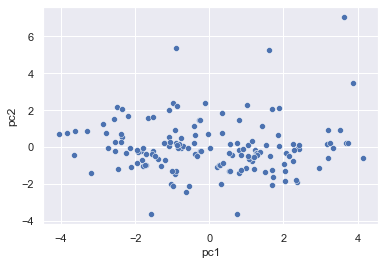

In [16]:
features = ['Stamina', 'Attack', 'Defense', 'MaxHP', 'MaxCP',] + list(types)
huef = 'Weight'
d = 2

x = pkmdex.loc[:, features].values
y = pkmdex.loc[:, huef].values
x = StandardScaler().fit_transform(x)
xp = do_pca()

In [17]:
# 3D stuff
'''%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = pc_df['pc1']
y = pc_df['pc2']
z = pc_df['pc3']

ax.scatter(x, y, z)

plt.show()'''

"%matplotlib widget\nfig = plt.figure()\nax = fig.add_subplot(111, projection = '3d')\n\nx = pc_df['pc1']\ny = pc_df['pc2']\nz = pc_df['pc3']\n\nax.scatter(x, y, z)\n\nplt.show()"

In [ ]:
features = ['temperature', 'windSpeed', 'pressure', 'population_density']
huef = 'Weight'
d = 2

x = df.loc[:, features].values
y = df.loc[:, huef].values
x = StandardScaler().fit_transform(x)
do_pca()

DB SCAN

In [18]:
from sklearn.cluster import DBSCAN

c:\Users\martin.ranieri\Downloads\spawn-em-all-manzi-2022\manzi\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\martin.ranieri\Downloads\spawn-em-all-manzi-2022\manzi\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\martin.ranieri\Downloads\spawn-em-all-manzi-2022\manzi\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other argume

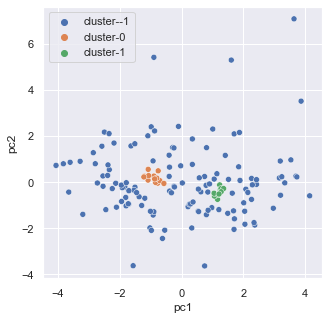

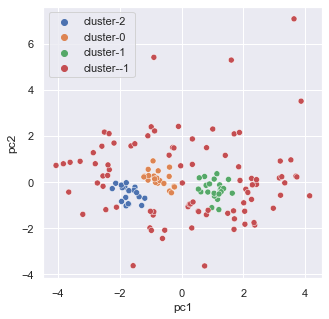

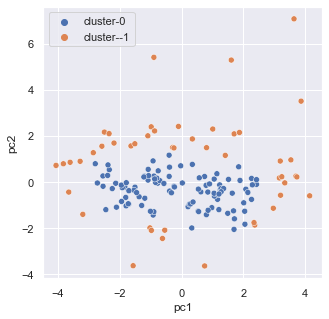

In [19]:
for e in [.35, .50, .75, ]:
    db = DBSCAN(eps=e, min_samples=10).fit(xp)
    labels = db.labels_
    fig = plt.figure(figsize=(5, 5))
    sns.scatterplot(xp.pc1, xp.pc2, hue=["cluster-{}".format(i) for i in labels])

### correspondence analisys

In [21]:
import prince

In [22]:
features = ['appearedTimeOfDay', 'weatherIcon', 'log_pd', 'closeToWater']
interesting_types = [f'{t}_y' for t in ['Fire', 'Water', 'Flying', 'Ice', 'Dragon', ]]
for f in features:
    print(set(df[f]))

{'evening', 'night', 'morning', 'afternoon'}
{'partly-cloudy-day', 'rain', 'clear-day', 'clear-night', 'wind', 'partly-cloudy-night', 'fog', 'cloudy'}
{1, 2, 3, 4, 5}
{False, True}


In [23]:
mca = prince.MCA()

X = df[features+interesting_types].astype(str)
r = mca.fit(X) # same as calling ca.fs_r(1)
q = mca.transform(X) # same as calling ca.fs_r_sup(df_new) for *another* test set.

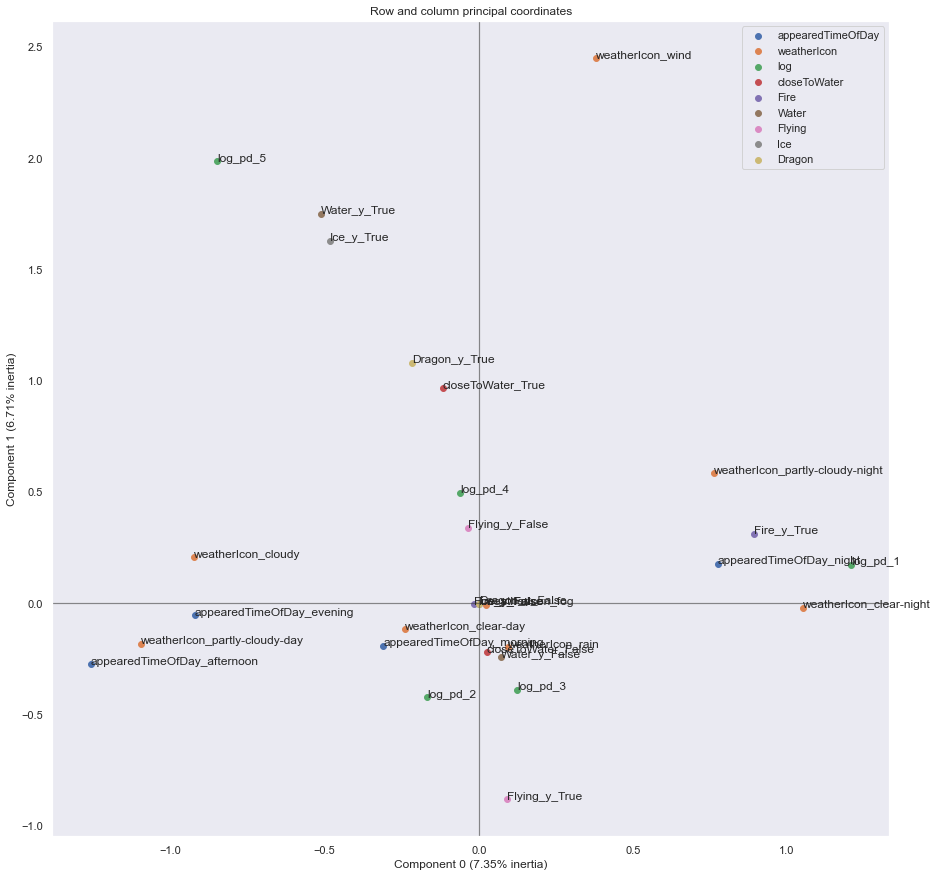

In [24]:
ax = mca.plot_coordinates(
     X=X,
     ax=None,
     figsize=(15, 15),
     show_row_points=False,
     row_points_size=5,
     show_row_labels=False,
     show_column_points=True,
     column_points_size=35,
     show_column_labels=True,
     legend_n_cols=1
)

### canonical correlation

In [25]:
from sklearn.cross_decomposition import CCA
# Multivatiate normal distribution assumptions are required for both sets of variables.

In [26]:
'''from collections import defaultdict
d = defaultdict(lambda: 0)
for i in df.pokestopDistanceKm:
    try:
        float(i)
    except:
        d[i]+=1
d'''

'from collections import defaultdict\nd = defaultdict(lambda: 0)\nfor i in df.pokestopDistanceKm:\n    try:\n        float(i)\n    except:\n        d[i]+=1\nd'

In [85]:
# Split the data in X and Y
czone_norm = ['temperature', 'windSpeed', 'pressure', 'population_density',]
interesting_types = [f'{t}_x' for t in ['Fire', 'Water', 'Flying', 'Ice', 'Dragon', ]]
X = df[czone_norm]
Y = df[cstat+interesting_types]

# Instantiate the Canonical Correlation Analysis with 2 components
my_cca = CCA(n_components=2)

# Fit the model
my_cca.fit(X, Y)

CCA()

In [86]:
label_list = list(X.columns) + list(Y.columns)
color_list = ['blue']*len(X.columns)+['red']*len(Y.columns)

for i in range(len(label_list)):
    if label_list[i].endswith('_x'):
        color_list[i] = 'green'
    if label_list[i].endswith('_y'):
        color_list[i] = 'green'

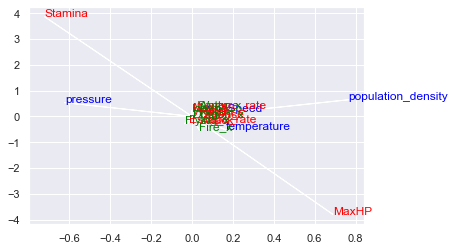

In [95]:
# Obtain the rotation matrices
xrot = my_cca.x_rotations_
yrot = my_cca.y_rotations_

# Put them together in a numpy matrix
xyrot = np.vstack((xrot,yrot))

nvariables = xyrot.shape[0]

plt.figure()
#plt.figure(figsize=(20, 16))
#plt.xlim((-0.10,0.20))
#plt.ylim((-0.80,0.50))

# Plot an arrow and a text label for each variable
for i in range(nvariables):
  x = xyrot[i,0]
  y = xyrot[i,1]

  plt.arrow(0,0,x,y)
  plt.text(x,y, label_list[i], color=color_list[i])

plt.show()

#### logistic

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.special import expit, logit
from sklearn.linear_model import LinearRegression

In [74]:
#X, y = df[['windSpeed','gymDistanceKm']].values , df.Dragon_y.values
X, y = df.gymDistanceKm.values, df.Dragon_y.values
X, y = X.reshape(-1, 1), y.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

'''x_train= x_train.reshape(-1, 1)
y_train= y_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)'''

logreg = LogisticRegression()
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)
print('log: ', metrics.accuracy_score(y_test, y_pred))

(222448, 1)
(55613, 1)
(222448, 1)
(55613, 1)


c:\Users\martin.ranieri\Downloads\spawn-em-all-manzi-2022\manzi\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


log:  0.9980040637980329


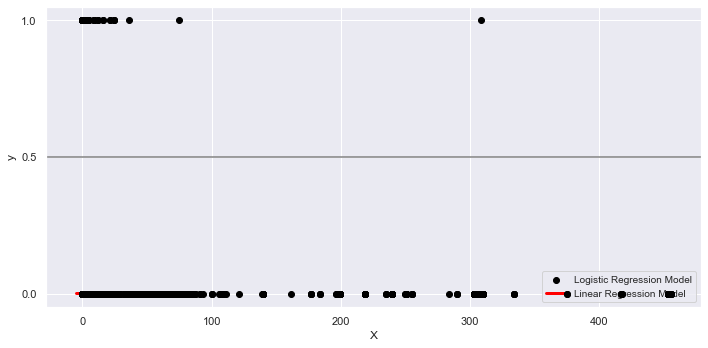

In [75]:
# and plot the result
plt.figure(1, figsize=(10, 5))
plt.clf()
plt.scatter(X.ravel(), y, color="black", zorder=20)

loss = expit(X_test * logreg.coef_ + logreg.intercept_).ravel()
plt.plot(X_test, loss, color="red", linewidth=3)

ols = LinearRegression()
ols.fit(X, y)
plt.plot(X_test.reshape(1, -1), ols.coef_ * X_test + ols.intercept_, linewidth=0.5)
plt.axhline(0.5, color=".5")

plt.ylabel("y")
plt.xlabel("X")
#plt.xticks(range(-5, 10))
plt.yticks([0, 0.5, 1])
#plt.ylim(-0.25, 1.25)
#plt.xlim(-4, 10)
plt.legend(
    ("Logistic Regression Model", "Linear Regression Model"),
    loc="lower right",
    fontsize="small",
)
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='temperature', ylabel='Density'>

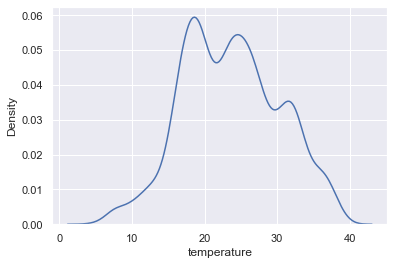

In [93]:
sns.kdeplot(data=df[df.Fire_y == True], x="d")

<AxesSubplot:xlabel='temperature', ylabel='Density'>

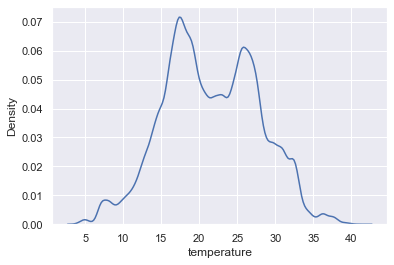

In [91]:
sns.kdeplot(data=df, x="temperature")

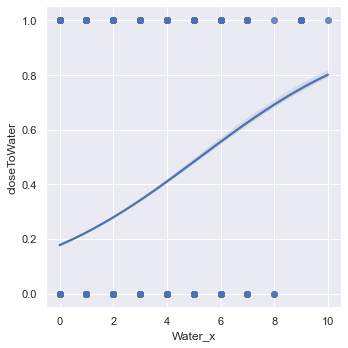

In [99]:
#pal = dict(True="#6495ED", False="#F08080")

# Show the survival probability as a function of age and sex
g = sns.lmplot(x="Water_x", y="closeToWater", data=df, logistic=True, n_boot=10)
#g.set(xlim=(0, 80), ylim=(-.05, 1.05))